# Обучение модели

## UNet с предобученными весами (Pretrained Backbones with UNet)
Это основанная на PyTorch библиотека Python с архитектурой UNet и множеством базовых компонентов (веса, архитектура модели и др.) для семантической сегментации изображений. Подгрузим эту библиотеку.

In [ ]:
!pip install pretrained-backbones-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## Импорт библиотек

In [ ]:
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import cv2
import numpy as np
import seaborn as sns

from backbones_unet.model.unet import Unet
from backbones_unet.model.losses import DiceLoss
from backbones_unet.utils.trainer import Trainer

from dataset import *
import objects
from utils import seed_everything, load_image

## Функции

In [ ]:
def make_dataloaders(paths):
  global SEED, TRAIN_IMG_DIR, TRAIN_MASK_DIR, BATCH_SIZE
  data_train, data_test = train_test_split(
                                  list(zip(paths, paths)),
                                  test_size=0.2,
                                  random_state=SEED
                                  )

  data_val, data_test = train_test_split(data_test, test_size=0.5,
                                    random_state=SEED
                                    )

  train = PlantsDataset(data_train, TRAIN_IMG_DIR, TRAIN_MASK_DIR,
                        preprocessing =  train_img_preprocessing)
  val   = PlantsDataset(data_val, TRAIN_IMG_DIR, TRAIN_MASK_DIR)
  test  = PlantsDataset(data_test, TRAIN_IMG_DIR, TRAIN_MASK_DIR)

  print("Train:", len(train))
  print("Val:", len(val))
  print("Test:", len(test))

  train_loader = DataLoader(train, batch_size=BATCH_SIZE,
                    shuffle=True, drop_last=True)
  val_loader = DataLoader(val, batch_size=BATCH_SIZE,
                  shuffle=False, drop_last=True)
  test_loader = DataLoader(test,
                    batch_size=BATCH_SIZE,
                  shuffle=False, drop_last=True)
  return train_loader, val_loader, test_loader



In [ ]:
def activate_model(path, device):
  model = Unet(
      backbone='convnext_base',
      in_channels=3,
      num_classes=1,
      )
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  model.to(device)
  return model

def score_model(model, data):
    model.eval()  # testing mode
    # prec = 0
    # rec = 0
    f1sc = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred = (Y_pred > 0).type(torch.uint8)
        for real, pred in zip(Y_label, Y_pred):
          TP, FP, FN = TF_labels_pix(real, pred)
          # prec += precision(TP, FP)
          # rec += precision(TP, FN)
          f1sc += f1(TP, FP, FN)
        # prec /= len(Y_label)
        # rec /= len(Y_label)
        f1sc /= len(Y_label)
    # return (prec / len(data), rec / len(data), f1sc / len(data))
    return f1sc / len(data)

def predict(model, data):
    global device
    model.eval()  # testing mode
    with torch.no_grad():
        data = data.to(device)
        pred = model(data)
        pred = (pred > 0).type(torch.uint8)
        return pred

def visual_test_model(img_name):
    # создадим маску и bounding box-ы для тестового изображения
    dataset_tests = PlantsDataset([(img_name, img_name)], TRAIN_IMG_DIR, TRAIN_MASK_DIR)
    pred_mask = predict(trainer.model, dataset_tests[0][0].unsqueeze(0))
    res = pred_mask.squeeze(0, 1).cpu().numpy()

    real_img  = load_image(os.path.join(TRAIN_IMG_DIR, img_name))
    real_mask = load_image(os.path.join(TRAIN_MASK_DIR, img_name))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.imshow(real_img)
    ax1.set_title('Source image')

    ax2.imshow(real_mask)
    ax2.set_title('Real mask')

    ax3.imshow(res)
    ax3.set_title('Predicted mask')

    return res, real_img, real_mask

def TF_labels_pix(real, pred):
  if isinstance(real, torch.Tensor):
      real = real.squeeze().cpu().numpy()
  if isinstance(pred, torch.Tensor):
      pred = pred.squeeze().cpu().numpy()

  H, W = pred.shape

  img_TP = pred.copy()
  img_FP = np.zeros((H, W), dtype=int)
  img_FN = np.zeros((H, W), dtype=int)

  for y in range(0, H):
    for x in range(0, W):
      if real[y, x] > 0.5 and pred[y, x] > 0.5:
        img_TP[y, x] = 1
      else:
        img_TP[y, x] = 0

      if (real[y, x] < 0.5) and (pred[y, x] > 0.5):
        img_FP[y, x] = 1
      else:
        img_FP[y, x] = 0

      if (real[y, x] > 0.5) and (pred[y, x] < 0.5):
        img_FN[y, x] = 1
      else:
        img_FN[y, x] = 0

  TP = img_TP.sum()
  FP = img_FP.sum()
  FN = img_FN.sum()

  return TP, FP, FN

def precision(TP, FP):
  if FP + TP:
    return TP / (TP + FP)
  return 0

def recall(TP, FN):
  if TP + FN:
    return TP / (TP + FN)
  return 0

def f1(TP, FP, FN):
  p = precision(TP, FP)
  r = recall(TP, FN)
  if p + r:
    return 2 * p * r / (p + r)
  return 0

In [ ]:
class CustomTrainer(Trainer):
  def __init__(
        self,
        model,
        criterion,
        optimizer,
        epochs,
        path_to_model,
        scaler=None,
        lr_scheduler=None,
        device=None
     ):
    super().__init__(
        model,
        criterion,
        optimizer,
        epochs,
        scaler,
        lr_scheduler,
        device
        )
    self.path_to_model = path_to_model
    self.best_vloss = float('inf')
    self.best_score = 0

  def fit(self, train_loader, val_loader):
        """
        Fit the model using the given loaders for the given number
        of epochs.

        Parameters
        ----------
        train_loader :
        val_loader :
        """
        # attributes
        self.train_losses_ = torch.zeros(self.epochs)
        self.val_losses_ = torch.zeros(self.epochs)
        # ---- train process ----
        for epoch in trange(1, self.epochs + 1,
                            desc='Traning Model on {} epochs'.format(self.epochs)):
            # train
            self._train_one_epoch(train_loader, epoch)
            # validate
            self._evaluate(val_loader, epoch)

            cur_score = score_model(self.model, val_loader)
            path_ending = f"{epoch}_{self.val_losses_[epoch - 1]:.4f}_vloss{cur_score:.4f}_score.pth"

            print("Current model score:", cur_score)
            print("Best model score:", self.best_score)

            if self.val_losses_[epoch - 1] < self.best_vloss:
              self.best_vloss = self.val_losses_[epoch - 1]
              torch.save(self.model.state_dict(),
                         self.path_to_model + path_ending)

            if cur_score > self.best_score:
               self.best_score = cur_score
               torch.save(self.model.state_dict(),
                          self.path_to_model + path_ending)

In [ ]:
def train_again(paths, version, model, epochs=10, lr=1e-4,
                best_score=None, best_vloss=None,
                path_to_model=None, params=None, optimizer=None):
  train_loader, val_loader, test_loader = make_dataloaders(paths)
  if path_to_model:
    model.load_state_dict(torch.load(path_to_model))
    model.to(device)
  if params is None:
    params = [p for p in model.decoder.parameters() if p.requires_grad]
  if optimizer is None:
    optimizer = torch.optim.AdamW(params, lr)
  trainer = CustomTrainer(
      model,                    # UNet model with pretrained backbone
      criterion=DiceLoss(),     # loss function for model convergence
      optimizer=optimizer,      # optimizer for regularization
      epochs=epochs,                # number of epochs for model training
      path_to_model=f'/content/drive/MyDrive/plants_detection/models/model_v0.{version}',
      device=device
  )
  if best_score:
    trainer.best_score = best_score

  if best_vloss:
    trainer.best_vloss = best_vloss

  trainer.fit(train_loader, val_loader)

## Основная программа

Подключаем Google Drive, чтобы иметь доступ к фотографиям для обучения модели.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Получаем список фотографий для обучения модели. Помним, что у нас названия файлов для карт растительности и для фотографий фрагментов поля совпадают.

In [ ]:
TRAIN_MASK_DIR = "/content/drive/MyDrive/plants_detection/dataset/mask"
TRAIN_IMG_DIR  = "/content/drive/MyDrive/plants_detection/dataset/img"

paths_all = os.listdir(TRAIN_IMG_DIR)

Из-за ограничений Google Colab  сократим обучающую выборку. В дальнейшем планируется сделать 42 раза обучение модели на разных выборках.

In [ ]:
SEED = 42
BATCH_SIZE = 10
EPOCHS = 10

seed_everything(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


Разбиваем данные и подготавливаем их для обучения модели.

In [ ]:
paths = paths_all
train_loader, val_loader, test_loader = make_dataloaders(paths)

Train: 6749
Val: 844
Test: 844


In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)

In [ ]:
trainer = CustomTrainer(
    model,                    # UNet model with pretrained backbone
    criterion=DiceLoss(),     # loss function for model convergence
    optimizer=optimizer,      # optimizer for regularization
    epochs=EPOCHS,                # number of epochs for model training
    path_to_model='/content/drive/MyDrive/plants_detection/models/model_v1.0',
    device=device
)

In [ ]:
trainer.fit(train_loader, val_loader)

Epoch 1: 100%|██████████| 674/674 [1:40:40<00:00,  8.96s/ training-batch, loss=0.849]

Validation: 100%|██████████| 84/84 [11:35<00:00,  8.28s/ validating-batch, loss=0.859]


Current model score: 0.0017749066404752628
Best model score: 0


Epoch 2: 100%|██████████| 674/674 [10:13<00:00,  1.10 training-batch/s, loss=0.865]

Validation: 100%|██████████| 84/84 [00:28<00:00,  2.96 validating-batch/s, loss=0.837]


Current model score: 0.002631043890257428
Best model score: 0.0017749066404752628


Epoch 3: 100%|██████████| 674/674 [10:07<00:00,  1.11 training-batch/s, loss=0.845]

Validation: 100%|██████████| 84/84 [00:28<00:00,  2.99 validating-batch/s, loss=0.833]


In [ ]:
model = activate_model("/content/drive/MyDrive/plants_detection/models/model_v1.02_0.8171_vloss0.0026_score.pth",
                       device)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


In [ ]:
train_again(paths_all,
            version=3,
            model=model,
            best_vloss=0.8171,
            best_score = 0.0026
            )

Train: 6749
Val: 844
Test: 844


Epoch 1: 100%|██████████| 674/674 [1:39:26<00:00,  8.85s/ training-batch, loss=0.855]

Validation: 100%|██████████| 84/84 [11:30<00:00,  8.22s/ validating-batch, loss=0.839]


Current model score: 0.002771271832229936
Best model score: 0.0026


Epoch 2: 100%|██████████| 674/674 [09:39<00:00,  1.16 training-batch/s, loss=0.861]

Validation: 100%|██████████| 84/84 [00:26<00:00,  3.11 validating-batch/s, loss=0.816]


Current model score: 0.0029676962400414487
Best model score: 0.002771271832229936


Epoch 3:  98%|█████████▊| 658/674 [09:25<00:13,  1.18 training-batch/s, loss=0.854]

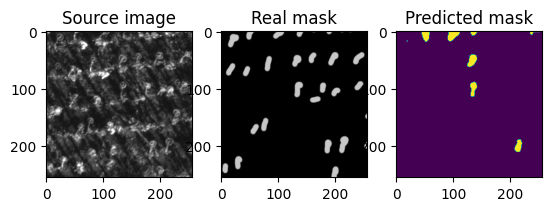

In [ ]:
pred_mask, _, _ = visual_test_model(paths_all[599])
